# Helicopter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from openmpc.mpc import MPCProblem, SetPointTrackingMPC
from openmpc.models  import  LinearSystem

In [2]:

# Helicopter Model Parameters
Je = 0.91  # kgm^2, Moment of inertia about elevation axis
la = 0.66  # m, Arm length from elevation axis to helicopter body
Kf = 0.5   # Motor Force Constant
Fg = 0.5   # N, Differential force due to gravity and counterweight
Tg = la * Fg  # Nm, Differential torque
Jp = 0.0364  # kgm^2, Moment of inertia about pitch axis
lh = 0.177  # m, Distance from pitch axis to either motor
Jt = Je  # Moment of inertia about travel axis

# Control input constraints
u_max = [3, 3]
u_min = [-2, -2]


# Linearize around elevation = 0, pitch = 0, position = 0
x_stat = np.array([0, 0, 0, 0, 0, 0])
u_stat = np.array([Tg / (2 * Kf * la), Tg / (2 * Kf * la)])

# Continuous-time state-space matrices
A = np.array([[0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, -Fg * la / Jt, 0],
              [0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0]])

B = np.array([[0, 0],
              [Kf * la / Je, Kf * la / Je],
              [0, 0],
              [0, 0],
              [0, 0],
              [Kf * lh / Jp, -Kf * lh / Jp]])

C = np.array([[1, 0, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0]])
D = np.zeros((2,2))


# Sampling time
h = 0.12

# Convert the system to discrete-time
sys_discrete = LinearSystem.c2d(A, B, C, D, h)



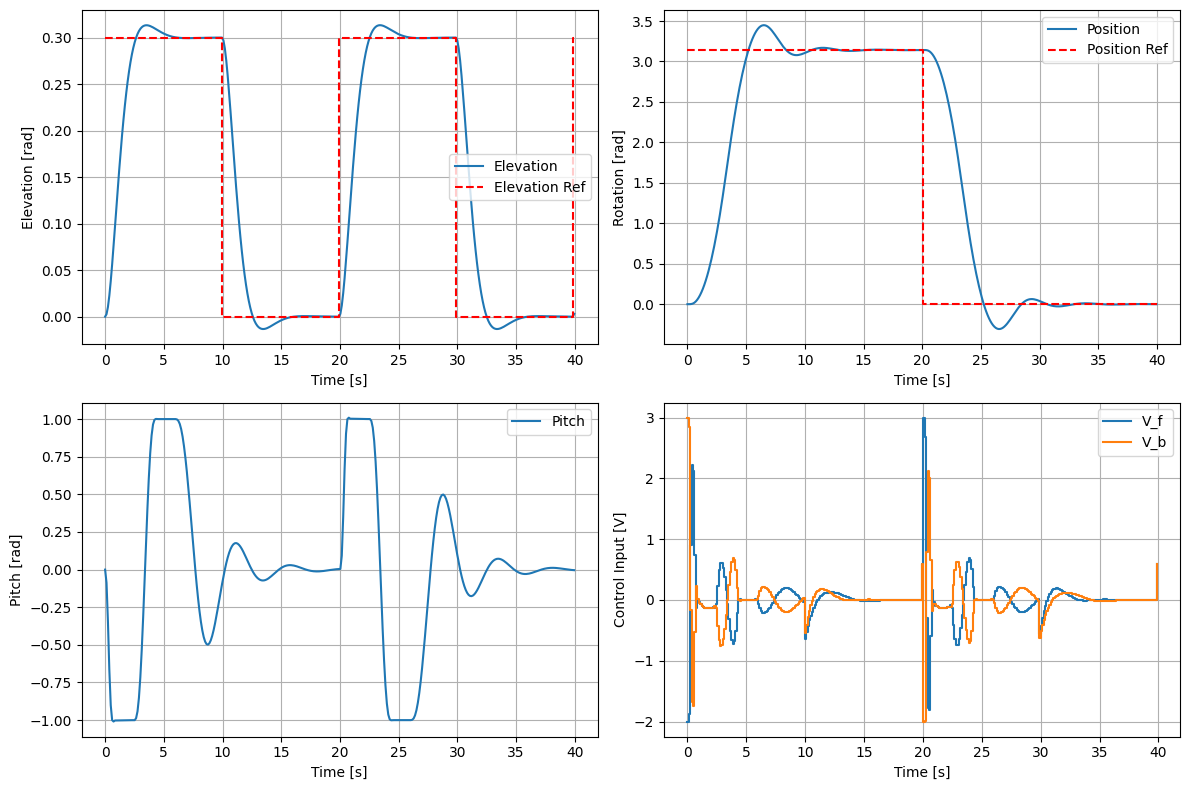

In [3]:


#MPC setup
horizon = 30  # Prediction horizon
Q = sys_discrete.C.T @np.diag([1, 1])@sys_discrete.C  # Output penalty
R = np.diag([0.1, 0.1])  # Input penalty

# Create the MPCProblem object
mpc_params = MPCProblem(system=sys_discrete, horizon=horizon, Q=Q, R=R)

# Add input constraints
mpc_params.add_input_bound_constraint( (-2, 3) )

# Add general state constraints

Cc = np.array([[1, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 1, 0]])
Dc = np.zeros((2,2))

z_max = np.array([0.6, 1])
z_min = np.array([-0.5, -1])

A_combined = np.vstack([Cc, -Cc])  
b_combined = np.hstack([z_max, -z_min])  

# Add the general state constraints
mpc_params.add_general_state_constraints(A_combined, b_combined, is_hard=False, penalty_weight=1000 )

# Initialize the TrackingMPC object
mpc_tracking = SetPointTrackingMPC(mpc_params)

# Simulation parameters

# Define the square wave function
def square_wave(time_steps, magnitude=1.0, period=10, offset_time=0, offset_amplitude=0):
    signal = np.zeros(time_steps)
    for t in range(offset_time, time_steps):
        cycle_position = (t - offset_time) % period
        if cycle_position < period / 2:
            signal[t] = magnitude + offset_amplitude
        else:
            signal[t] = -magnitude + offset_amplitude
    return signal

# Simulation parameters
T_sim = int(40 / h)  # Total simulation steps for 40 seconds
x0 = np.zeros(6)  # Initial state
x_sim = np.zeros((6, T_sim + 1))
# Initialize u_sim as a 2D array to handle multiple control inputs
u_sim = np.zeros((T_sim, B.shape[1]))  # Adjust for the number of control inputs
x_sim[:, 0] = x0

# Generate the square wave references
elevation_reference = square_wave(T_sim, magnitude=0.15, period=int(20 / h), offset_amplitude=0.15)
rotation_reference = square_wave(T_sim, magnitude=np.pi / 2, period=int(40 / h), offset_amplitude=np.pi / 2)

# Combine references into a reference array for plotting
reference_array = np.zeros((2, T_sim))
reference_array[0, :] = elevation_reference
reference_array[1, :] = rotation_reference


# Simulation loop
for t in range(T_sim):
    current_state = x_sim[:, t]
    # Set references
    reference = np.array([elevation_reference[t], rotation_reference[t]])

    # Get control action based on estimated state and disturbance
    u_t = mpc_tracking.get_control_action(current_state, reference)
    
    # Flatten u_t and store in u_sim
    u_sim[t, :] = u_t.flatten()

    # Update system dynamics (assuming zero disturbance for simplicity)
    x_sim[:, t + 1] = sys_discrete.A @ current_state + sys_discrete.B @ u_t.reshape(-1, 1).flatten()
    
# Plotting the simulation results
time = np.arange(T_sim + 1) * h

plt.figure(figsize=(12, 8))

# Extend reference_array to match the time dimension of x_sim
reference_array_extended = np.hstack([reference_array, reference_array[:, -1].reshape(-1, 1)])


# Elevation plot
plt.subplot(2, 2, 1)
plt.plot(time, x_sim[0, :], label='Elevation')
plt.step(time, reference_array_extended[0, :], where='post', linestyle='--', color='r', label='Elevation Ref')
plt.xlabel('Time [s]')
plt.ylabel('Elevation [rad]')
plt.legend()
plt.grid()

# Pitch plot
plt.subplot(2, 2, 3)
plt.plot(time, x_sim[4, :], label='Pitch')
plt.xlabel('Time [s]')
plt.ylabel('Pitch [rad]')
plt.legend()
plt.grid()

# Position plot
plt.subplot(2, 2, 2)
plt.plot(time, x_sim[2, :], label='Position')
plt.step(time, reference_array_extended[1, :], where='post', linestyle='--', color='r', label='Position Ref')
plt.xlabel('Time [s]')
plt.ylabel('Rotation [rad]')
plt.legend()
plt.grid()

# Control input plot (for each input)
plt.subplot(2, 2, 4)
plt.step(time[:-1], u_sim[:, 0], where='post', label='V_f')
plt.step(time[:-1], u_sim[:, 1], where='post', label='V_b')
plt.xlabel('Time [s]')
plt.ylabel('Control Input [V]')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
